In [2]:
%matplotlib inline
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
import glob
import datetime

# here are the GEE declarations. 
import ee
ee.Initialize()

# asset to extract. If image collection, convert to single image with stacked bands
# right now it's an ET image where the bands are named "bYYYY-MM"
# this can be adjusted as we find different datasets we want to mess with
to_extract = ee.Image("users/daviddralle/bessv2")
# specify an extracted variable name
# no / used cause will be used in filename
varname = 'ET [mm month-1]'

# here, define a function that takes the bands of the image
# and returns the datetimes corresponding to each band
# this function will need to be edited for different datasets
def get_datetimes(ft):
    bands = [item for item in ft.keys()]
    datelist = [pd.to_datetime(band[1:]) for band in bands]
    return datelist

# list of features to extract from
# for now, just using Dry Creek and Elder Creek polygons
# each polygon/point needs a column titled "Site"
dry = ee.Feature(ee.FeatureCollection("users/daviddralle/dry").first())
elder = ee.Feature(ee.FeatureCollection("users/daviddralle/elder").first())
fts_list = [elder.set('Site', 'Elder Creek'), 
              dry.set('Site', 'Dry Creek')]

# Extract site ET data

Text(0, 0.5, 'ET [mm month-1]')

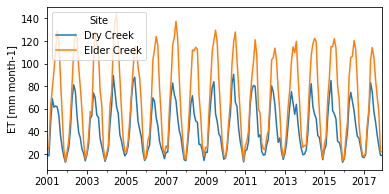

In [3]:
dfs = []
for i,ft in enumerate(fts_list):
    extracted_ft = to_extract.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=ft.geometry()
    ).getInfo()
    datelist = get_datetimes(extracted_ft)
    vals = [item for item in extracted_ft.values()]
    temp = pd.DataFrame.from_dict({'Site':ft.get('Site').getInfo(), varname:vals})
    temp.index = datelist
    temp = temp.sort_index()
    dfs.append(temp)
    
df_long = pd.concat(dfs)
df = df_long.pivot(columns='Site', values=varname)
df.to_csv('../data/' + varname + '.csv')

f, ax = plt.subplots(1, figsize=(6,3))
df.plot(ax=ax)
ax.set_ylabel(varname)

# Extract PRISM data

This takes a while because we are downloading daily data from the PRISM dataset. Since Google Earth Engine limits the number of elements that can be passed through the Python API to the client, we must extract PRISM variables one year at a time. 

In [10]:
fts = ee.FeatureCollection(fts_list)
def extract(image):
        val = image.reduceRegions(fts, ee.Reducer.mean())
        return val

def get_prism(minyear, maxyear, variable):
    dfs = []
    for year in range(minyear, maxyear):
        print('Getting %s, year %s'%(variable,str(year)))
        prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81d').select(variable).filterDate(str(year),str(year+1))
        extracted = prism.map(extract).flatten().getInfo()
        sites = []
        vals = []
        dates = []
        for feat in extracted['features']:
            site = feat['properties']['Site']
            val = feat['properties']['mean']
            date = pd.to_datetime(feat['id'].split('_')[0])
            sites.append(site), vals.append(val), dates.append(date)     
        df = pd.DataFrame(vals, index=dates, columns=[variable])
        df['site'] = sites
        df = df.pivot(columns='site')
        dfs.append(df)
    prism = pd.concat(dfs)
    return prism
    
current_date = pd.to_datetime(datetime.datetime.today().strftime('%Y-%m-%d')) - pd.to_timedelta(7, unit='d')
current_water_year = current_date.year + 1*int((current_date.month>=10)&(current_date.month<=12))

variable = 'ppt'
prism_ppt = get_prism(2000, current_water_year, variable)
prism_ppt.to_csv('../data/elder_dry_prism_ppt.csv')

variable = 'tmax'
prism_tmax = get_prism(2000, current_water_year, variable)
prism_tmax.to_csv('../data/elder_dry_prism_tmax.csv')

variable = 'tmin'
prism_tmin = get_prism(2000, current_water_year, variable)
prism_tmin.to_csv('../data/elder_dry_prism_tmin.csv')

Getting ppt, year 2000
Getting ppt, year 2001
Getting ppt, year 2002
Getting ppt, year 2003
Getting ppt, year 2004
Getting ppt, year 2005
Getting ppt, year 2006
Getting ppt, year 2007
Getting ppt, year 2008
Getting ppt, year 2009
Getting ppt, year 2010
Getting ppt, year 2011
Getting ppt, year 2012
Getting ppt, year 2013
Getting ppt, year 2014
Getting ppt, year 2015
Getting ppt, year 2016
Getting ppt, year 2017
Getting ppt, year 2018
Getting ppt, year 2019
Getting tmax, year 2000
Getting tmax, year 2001
Getting tmax, year 2002
Getting tmax, year 2003
Getting tmax, year 2004
Getting tmax, year 2005
Getting tmax, year 2006
Getting tmax, year 2007
Getting tmax, year 2008
Getting tmax, year 2009
Getting tmax, year 2010
Getting tmax, year 2011
Getting tmax, year 2012
Getting tmax, year 2013
Getting tmax, year 2014
Getting tmax, year 2015
Getting tmax, year 2016
Getting tmax, year 2017
Getting tmax, year 2018
Getting tmax, year 2019
Getting tmin, year 2000
Getting tmin, year 2001
Getting tmin

In [12]:
# Calculating winter PET
import meteolib as meteo
import evaplib as evap
tmax = pd.read_csv('../data/elder_dry_prism_tmax.csv', parse_dates=True, index_col=0, header=1)
tmin = pd.read_csv('../data/elder_dry_prism_tmin.csv', parse_dates=True, index_col=0, header=1)
rng = tmax.index
# Using Eqn 50 From Allen (1998) to get solar radiation from max/min temp difference
kRs = 0.18
doy = [rng[i].timetuple().tm_yday for i in range(len(rng))]
N, Rext = meteo.sun_NR(doy,39.666)
Rext_MJ = Rext/(10.0**6)

dfs = []
for col in tmax.columns:
    tmaxcurr = tmax[col]
    tmincurr = tmin[col]
    tmeancurr = (tmaxcurr+tmincurr)/2.0
    Rs = kRs*np.sqrt(tmaxcurr-tmincurr)*Rext
    pet = evap.hargreaves(tmincurr, tmaxcurr, tmeancurr, Rext_MJ)
    dfs.append(pd.DataFrame(pet.values, index=pet.index, columns=[col]))
pet = pd.concat(dfs, axis=1)
pet.to_csv('../data/elder_dry_pet.csv')

/opt/anaconda3/envs/py3k/lib/python3.6/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
